# Import Statements

In [89]:
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

# One Hot Encoding the Target Classes

In [90]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]]) 

# 0 - Tumor
# 1 - Normal

OneHotEncoder()

# Creating 3 Important Lists --
1. data list for storing image data in numpy array form
2. paths list for storing paths of all images
3. result list for storing one hot encoded form of target class whether normal or tumor

In [91]:
# This cell updates result list for images with tumor

data = []
paths = []
result = []

for r, d, f in os.walk(r'../input/augmented-dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [92]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"../input/augmented-dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [93]:
data = np.array(data)
data.shape

(2063, 128, 128, 3)

In [94]:
result = np.array(result)
result = result.reshape(2063,2)

# Splitting the Data into Training & Testing

In [95]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# Model Building

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [96]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax', metrics = ["accuracy"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)       

In [97]:
y_train.shape

(1650, 2)

In [98]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='BRAIN_model.hdf5',
                            verbose=1,
                            save_best_only=True)
my_callbacks = [es, checkpoint]

In [99]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test), callbacks=[es,checkpoint])

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 8.6526 - accuracy: 0.6976
Epoch 00001: val_loss improved from inf to 3.58528, saving model to BRAIN_model.hdf5
42/42 [==============================] - 58s 1s/step - loss: 8.6526 - accuracy: 0.6976 - val_loss: 3.5853 - val_accuracy: 0.6247
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.2368 - accuracy: 0.7758
Epoch 00002: val_loss improved from 3.58528 to 0.84337, saving model to BRAIN_model.hdf5
42/42 [==============================] - 59s 1s/step - loss: 1.2368 - accuracy: 0.7758 - val_loss: 0.8434 - val_accuracy: 0.7433
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.8327
Epoch 00003: val_loss improved from 0.84337 to 0.66687, saving model to BRAIN_model.hdf5
42/42 [==============================] - 71s 2s/step - loss: 0.4580 - accuracy: 0.8327 - val_loss: 0.6669 - val_accuracy: 0.7772
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 

In [100]:
model.save("brain_tumor.model", save_format="h5")

In [101]:
history = model.history.history

In [102]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


# Plotting Losses

In [103]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure(figsize=(15,5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

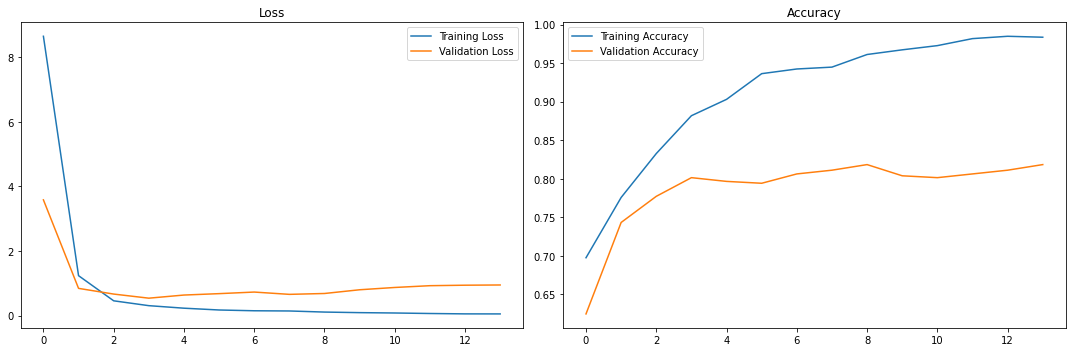

In [104]:
plot_metrics(history)

# Just Checking the Model

In [105]:
from tensorflow.keras.models import Model, load_model
loadmodel = load_model(filepath='./brain_tumor.model')

In [106]:
loadmodel.metrics_names

['loss', 'accuracy']

In [107]:
loss, acc = loadmodel.evaluate(x=x_test, y=y_test)

13/13 [==============================] - 3s 211ms/step - loss: 0.9485 - accuracy: 0.8184


In [108]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.9484750032424927
Test Accuracy = 0.8184019327163696


In [109]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

61.39148473739624% Confidence This Is No, Its not a tumor


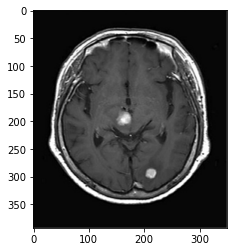

In [110]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-mri-images-for-brain-tumor-detection/no/N17.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

99.98968839645386% Confidence This Is A Its a Tumor


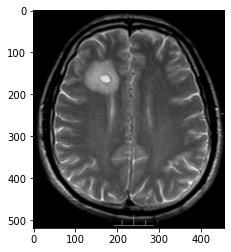

In [111]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-mri-images-for-brain-tumor-detection/yes/Y3.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))

# Thats It !!